# Final Project
#### Harris Dupre
#### Data 612, Summer 2020

## Introduction

This final project will be a hybrid book recommender system implemented in Python using the goodbooks data found here:

https://www.kaggle.com/zygmunt/goodbooks-10k

The goodbooks dataset contains six million total ratings, with ten thousand books and fifty thousand users. However, this size set was prohibitively large, so the set I used has just over one million ratings.

My intention was to use the sci-kit Surprise library to generate prediction matrices, processing time, and RMSE data on a number of different recommender algorithms and compare the results. My ultimate goal was to create a hybridized recommender system that would aggregate the user-item rating predictions and assign varying weights based on prediction algorithm that generated a particular value.

This did not go as planned (as I will discuss in the sci-kit Surprise section below). Instead I generated an SVD prediction matrix to using the numpy linear algebra library to start my recommendation list, then used a "nearest neighbors" function to find similar books that the user might be interested in.


## Preliminary Data Analysis

In [653]:
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import train_test_split
from surprise import SVD, SlopeOne, BaselineOnly, NormalPredictor

r = pd.read_csv('ratings.csv')
r = r[r['user_id'].isin(r['user_id'].value_counts().head(7000).index.tolist())]

tr = pd.read_csv('to_read.csv')
b = pd.read_csv('books.csv')
t = pd.read_csv('tags.csv')

bt = pd.read_csv('book_tags.csv')
bt = bt.merge( t, on = 'tag_id' )
bt = bt.merge( b[[ 'goodreads_book_id', 'title']], on = 'goodreads_book_id' )

### Ratings DataFrame

The ratings dataframe, read from 'ratings.csv' will be the core of the recommender system as its user-item combinations, and the corresponding ratings, will be used to train prediction models.

Note that while loading the data I selected the top 7000 users who had the most books rated. This change saved me about five million records.

In [655]:
r.head(6)

,user_id,book_id,rating
977,75,3254,2
978,75,6777,5
979,75,11,5
981,75,372,4
982,75,476,3
983,75,115,4


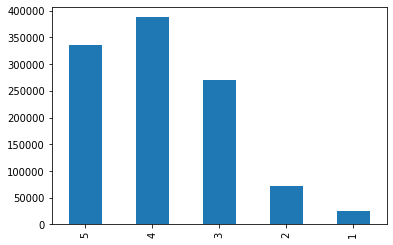

In [658]:
r['rating'].value_counts().loc[[5,4,3,2,1]].plot(kind='bar', )
plt.show()

We can see that that the most common rating is 4, with the vast majority of ratings being 3 or more.

### Book DataFrame

This dataframe also plays an important role as it stores data about each book item.

In [197]:
# Book file
b.head(3)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...


## Sci-Kit Surprise as a Recommender Tool

As I stated earlier, my intention was to use the Surprise library to generate all my prediction data, and then use that data to create a hybridized recommender system.

I used this library with good success on Project 4, and it allowed me to compare SVD, user-based collaborative filtering, and item-based collaborative filtering -- but the dataset was much smaller.

Surprise worked decently well on this dataset with certain algorithms while only generating a prediction matrix for a portion of the data.

Collaborative filtering algorithms and prediction matrices for the whole set were not possible.

In [659]:
# create a reader that takes the rating scale as a parameter
# use the load_from_df function to load our book ratings dataframe
# split data into a training set and a test set with an 80/20 ratio
trainset, testset = train_test_split(Dataset.load_from_df(r[['user_id', 'book_id','rating']], Reader(rating_scale=(1,5))), test_size=0.2)

In [660]:
# Surprise recommender algorithm functions
algo_svd = SVD()
algo_so = SlopeOne()
algo_bslo = BaselineOnly()
algo_np = NormalPredictor()

### Training the models

In [661]:

tic = timeit.default_timer()
algo_svd.fit(trainset)
toc = timeit.default_timer()
time_a = round(toc-tic,4)

In [662]:
tic = timeit.default_timer()
algo_so.fit(trainset)
toc = timeit.default_timer()
time_b = round(toc-tic,4)

In [663]:
tic = timeit.default_timer()
algo_bslo.fit(trainset)
toc = timeit.default_timer()
time_c = round(toc-tic,4)

Estimating biases using als...


In [664]:
tic = timeit.default_timer()
algo_np.fit(trainset)
toc = timeit.default_timer()
time_d = round(toc-tic,4)

### Generating predictions for test data

In [665]:
tic = timeit.default_timer()
pred_svd = algo_svd.test(testset)
toc = timeit.default_timer()
time1 = round(toc-tic,4)

In [666]:
tic = timeit.default_timer()
pred_so = algo_so.test(testset)
toc = timeit.default_timer()
time2 = round(toc-tic,4)

In [667]:
tic = timeit.default_timer()
pred_bslo = algo_bslo.test(testset)
toc = timeit.default_timer()
time3 = round(toc-tic,4)

In [668]:
tic = timeit.default_timer()
pred_np = algo_np.test(testset)
toc = timeit.default_timer()
time4 = round(toc-tic,4)

In [670]:
pd.DataFrame([['SVD',accuracy.rmse(pred_svd).round(4),time_a,time1],['SlopeOne',accuracy.rmse(pred_so).round(4),time_b,time2],['BaselineOnly',accuracy.rmse(pred_bslo).round(4),time_c,time3],['NormalPredictor',accuracy.rmse(pred_np).round(4),time_d,time4]],columns=['Algorithm','RMSE','Training Time','Prediction Values Time'])

RMSE: 0.8415
RMSE: 0.8519
RMSE: 0.8553
RMSE: 1.3386


,Algorithm,RMSE,Training Time,Prediction Values Time
0,SVD,0.8415,46.6264,2.2481
1,SlopeOne,0.8519,13.0015,26.6556
2,BaselineOnly,0.8553,2.2488,1.3278
3,NormalPredictor,1.3386,0.9158,1.9912


SVDs training time was the longest, but compared to generating the overall prediction matrix for SVD (which took 3-4 hours) it was nothing.

SVD had the lowest RMSE while the NormalPredictor had the highest, as was expected for both.

The commented out functions below could not be run on my hardware, they took hours to run and I never successfully ran all three without the kernel failing. Kernel failure is particularly rough if you've already generated data from a long-running process and you have to start all over.

In [671]:
# pred_svd_full = algo_svd.test(trainset.build_anti_testset())
# pred_so_full = algo_so.test(trainset.build_anti_testset())
# pred_bslo_full = algo_bslo.test(trainset.build_anti_testset())

## Doing SVD a different way

Because I was unable to generate predictions for all my data using Surprise, I turned to using the svd functions of the numpy.linalg library. This had worked well for me in Project 3 and I was hoping that performance would be better using numpy and pandas to do matrix calculations. 

### Create a matrix of user-item pairs

In [672]:
r_mat = r.pivot_table(index='user_id', columns='book_id', values='rating')

In [673]:
r_mat.head()

book_id,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,
7,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,4.0,5.0,NaN,NaN,NaN,4.0,NaN,4.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,4.0,3.0,NaN,4.0,4.0,NaN,4.0,4.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Using numpy.linalg.svd() to generate a prediction matrix for all the data

Note that I replaced all the NaN with 0 when I passed r_mat to svd()

In [674]:
tic = timeit.default_timer()
u, s, v_t = np.linalg.svd(r_mat.replace(np.nan, 0), full_matrices=False)
toc = timeit.default_timer()
print('Processing time: ', round(toc-tic,4),' seconds.')

Processing time:  179.3497  seconds.


Not a short processing time but far better than Surprise's hours of processing time.

In [675]:
print(u.shape,s.shape,v_t.shape)

(7000, 7000) (7000,) (7000, 9888)


In [676]:
tic = timeit.default_timer()
svd_prediction_df = pd.DataFrame(np.dot(u, np.dot(np.diag(s),v_t)), columns= r_mat.columns, index=r_mat.index)
toc = timeit.default_timer()
print('Processing time: ', round(toc-tic,4),' seconds.')

Processing time:  14.0039  seconds.


### Writing recommender_svd() to retrieve top user predictions.

This function is adapted from one I wrote for the Movie Lens dataset in Project 3.

The function finds the highest user-item combination values for given user, and outputs a list of book titles.

In [677]:
def recommender_svd(user_id, svd_prediction_df,b):
    # column of the selected user's predicted ratings
    user = svd_prediction_df.loc[user_id, :].sort_values(ascending=False)
    
    i=0
    j=0
    list_svd = []
    
    while i < 20:
        # if the user rating is NaN in the ratings pivot, the user didn't rate the selected book so it 
        # can be recommended. Otherwise, skip.
        if (np.isnan(r_mat.at[user_id,user.index[j]])):
            title = b[b['book_id']==user.index[j]]['original_title'].to_string(index=False).strip()
            list_svd.append(title)
            
            i += 1
            j += 1
        else:
            j += 1
        
    return pd.DataFrame(list_svd)

## Recommender_knn() to diversify predictions a bit

I adapted this function from a function I wrote for Project 2 which dealt with the Jokes data.

The function takes a user matrix with user_id as the columns and book_id as the index.

Again I replace NaN with 0.

In [276]:
r_user = r.pivot(index='book_id', columns='user_id', values='rating').fillna(0)

In [678]:
r_user.head(6)

user_id,7,35,41,75,89,143,145,146,153,158,...,53293,53318,53332,53337,53352,53364,53366,53373,53381,53403
book_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,5.0,4.0,4.0,5.0,0.0,0.0,0.0,0.0,...,0.0,4.0,5.0,4.0,5.0,0.0,4.0,5.0,5.0,0.0
2,0.0,0.0,0.0,5.0,3.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,5.0,0.0,4.0,5.0,5.0,4.0
3,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,...,0.0,2.0,1.0,4.0,0.0,0.0,5.0,3.0,4.0,0.0
4,0.0,0.0,0.0,0.0,4.0,0.0,3.0,5.0,0.0,4.0,...,0.0,0.0,5.0,5.0,1.0,4.0,3.0,4.0,5.0,0.0
5,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,4.0,0.0,0.0,3.0,2.0,5.0,0.0
6,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,4.0,0.0,...,0.0,4.0,5.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0


In [728]:
user_mat = csr_matrix(r_user.values)
knn = NearestNeighbors(metric='cosine', algorithm = 'brute', n_neighbors=20)
knn.fit(user_mat)

In [736]:
def recommender_knn(book_id, user_mat):
    book_id -= 1
    list_knn = []
    
    distances, indices = knn.kneighbors(user_mat[book_id], n_neighbors=5)
    
    for i in range(5):
        list_knn.append(b['original_title'][indices[0][i]])
        
    return pd.DataFrame(list_knn)

## Get_nearest

The idea here is the get the top 20 book recommendations from the SVD prediction matrix, then find the five nearest neighbors each of those top 20.

In [704]:
def get_nearest(fav_ids):
    frames = []
    for i in range(len(fav_ids)):
        frames.append((recommender_knn(fav_ids[i], user_mat)))
    df=pd.concat(frames,sort=False)
    return df

In [742]:
get_nearest([7])

,0
0,The Hobbit or There and Back Again
1,The Fellowship of the Ring
2,Harry Potter and the Philosopher's Stone
3,Nineteen Eighty-Four
4,"The Lion, the Witch and the Wardrobe"


## The recs function

The recs() function puts it together by generating a top 20 dataframe of books for a user, finding the nearest neighbors of those 20 books and putting them in a dataframe, and then selecting from both of those dataframe to develop a final recommendation list.

The first five results of the final list are the top 5 SVD predictions, while the other five are the most commonly recommended neighbors of the SVD predictions.

In [768]:
def recs(user_id):
    
    # get svd recommendations
    df_svd = recommender_svd(user_id, svd_prediction_df,b)
    
    # get the ids of the svd recommendations
    fav_ids = b[b['original_title'].isin(df_svd[0])]['book_id'].reset_index(drop=True)
    
    # calculate nearest neighbors to the fav_ids
    nearest_df = pd.DataFrame(get_nearest(fav_ids)[0].value_counts().index)
    nearest_df = nearest_df[~nearest_df[0].isin(df_svd[0])][0:5]
    
    # output a list that is half SVD, half nearest neighbors.
    print("Your recommendations are: ")
    return pd.concat([df_svd[0][0:5],nearest_df[0][0:5]]).reset_index(drop=True)
    
    

In [780]:
recs(7)

Your recommendations are: 


0    The Adventures of Huckleberry Finn
1                Much Ado About Nothing
2                   Death of a Salesman
3                  The Call of the Wild
4     Charlie and the Chocolate Factory
5          The Adventures of Tom Sawyer
6                      Of Mice and Men 
7                   The Glass Menagerie
8             A Midsummer Night's Dream
9                       Charlotte's Web
Name: 0, dtype: object

American Classics

In [781]:
recs(41)

Your recommendations are: 


0                        Nineteen Eighty-Four
1                            The Great Gatsby
2    Harry Potter and the Philosopher's Stone
3         Harry Potter and the Goblet of Fire
4        Harry Potter and the Deathly Hallows
5                             Charlotte's Web
6                       The Lord of the Rings
7                                   The Giver
8          The Hobbit or There and Back Again
9                          Lord of the Flies 
Name: 0, dtype: object

In [785]:
recs(153)

Your recommendations are: 


0                      The Catcher in the Rye
1                             Angels & Demons
2                             The Kite Runner
3    Harry Potter and the Prisoner of Azkaban
4                                   Gone Girl
5                       To Kill a Mockingbird
6                            The Kite Runner 
7         Harry Potter and the Goblet of Fire
8      Harry Potter and the Half-Blood Prince
9                            The Great Gatsby
Name: 0, dtype: object

Thrillers and fantasy

### Conclusion and Areas of Improvement

It appears to me that the final predictions heavily favor American literary classics and some fantasy books. It's possible that subsetting the way I did (almost all users here have rated almost 200+ books) introduced some bias.

With more time and processing power I would like to use the Surprise algorithms to generate the prediction matrices -- I think their uniform formats would make them easy to work with.

In hindsight I went into this project with too many unknowns. Without knowing exactly what datatypes/data structures these functions would give me it was difficult to accurately gauge how much work it would be to transform the data into useable predictions, and then try hybridize those predictions in a meaningful way.

The code itself needs some input control functions. Right now the rec() function will fail if it is given a user_id that does not exist. Instead it should warn the user on input and ask for a valid input.

I would have liked to use the code I wrote below for word analysis of the tags that are attached to each book record.

My idea was to have some kind of genre filtering and more recommendations based on books that have similar tags to the favorites -- but time was limited.

However, I did notice as I was working on this I was more easily navigating panda's dataframes and extracting the data I needed, and I was writing while using fewer variables behind taking up memory.

In [45]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df=0,stop_words='english')

In [46]:
tfidf_matrix = tf.fit_transform(t['tag_name'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix) 
results = {}
for idx, row in t.iterrows():
   similar_indices = cosine_similarities[idx].argsort()[:-100:-1] 
   similar_items = [(cosine_similarities[idx][i], t['tag_name'][i]) for i in similar_indices] 
   results[row['tag_name']] = similar_items[1:]

In [51]:
results['non-fiction'][:10][1]

(0.9999999999999999, '2-non-fiction')

In [55]:
results['non-fiction'][:5]

[(0.9999999999999999, 'non-fiction-etc'),
 (0.9999999999999999, '2-non-fiction'),
 (0.9999999999999999, 'non-fiction-other'),
 (0.9999999999999999, 'all-non-fiction'),
 (0.9999999999999999, 'j-non-fiction')]

In [180]:
def tag_find(tag_id):
    tag_name = btt[btt['tag_id']==tag_id]['tag_name'].to_string(index=False).strip()
    tag_name = tag_df[int(tag_df.index.values)]
    tags = []
    for x in range(5):
        tags.append(results[tag_name][:5][x][1])
    return tags

In [185]:
tag_find(69)

['00-to-read-00',
 'exploring-author',
 'exploring-classics',
 'exploring-quality',
 '00-in-class']

In [256]:
btt[btt['tag_id']==tag_id]['tag_name'].to_string(index=False).strip()

'--3-'